# Мобильные приложения — Выделение групп пользователей на основе поведения


## Материалы
 * [Дашборд](https://public.tableau.com/app/profile/anastasia.potekhina/viz/Mobile_apps_01/Dashboard1?publish=yes)
 * [Презентация](https://drive.google.com/file/d/1EDcMEbr7IXhkQvBag5EVxz2fILVVxhjO/view?usp=sharing)

# Оглавление
1. [Описание исследования](#title)
2. [Предобработка данных](#preprocessing)
  * [Подключение библиотек](#import)
  * [Загрузка данных и получение общей информации](#info)
  * [Проверка корректности наименований колонок и переименование](#column_names)
  * [Исследование пропущенных значений и замена](#missed_items)
  * [Исследование соответствия типов и преведение в соотвествие](#types)
  * [Исследование наличия дубликатов и удаление](#duplicates)

 
3. [Исследовательский анализ данных](#eda)
 * [Изучение общих характеристик](#general)
 * [Определение длительности сессии](#duration)
 * [Выделение сессий](#session)
 * [Расчет DAU (количество уникальных пользователей в день) и WAU (количество уникальных пользователей в неделю)](#dau_mau)

4. [Сегментация пользователей на основе действий](#segmentation)
 * [Формирование исходных данных для кластеризации](#table)
 * [Cтандартизация данных](#std)
 * [Матрица состояний и определяем количество кластеров](#dendrogram)
 * [Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов](#KMeans)
 * [Сравнение мерик (retention rate, время проведенное в приложении, частота действий, конверсия в целевое действие) по каждому из полученных кластеров](#metrics)

5. [Проверка гипотез](#hypothesis)
 * [1. Две группы пользователей (одни - установили приложение по ссылке из yandex ,другие — из google) демонстрируют разную конверсию в просмотры контактов](#1hypothesis)
 * [1. Две группы пользователей (одни - совершают в приложении ,больше действий(к примеру больше 15 ,другие — меньше) демонстрируют разную конверсию в просмотры контактов](#2hypothesis)
6. [Общий вывод](#conclusion)

<a id="title"></a> 
## Описание исследования

**Цели исследования:**
 * Понять пользователей
 * Оценить ключевые характеристики аудитории
 * Работать с аудиторией

**Задачи исследования:**
 - какие пользователи какие пользователи склонны часто возвращаться в мобильное приложение?
 - какие пользователи часто делают целевое событие? 
 - как различается время между распространенными событиями пользователей (например, различаются ли пользователи по группам на основе времени, которое проходит с момента первого использования мобильного приложения и до использования функции поиска)?

**Описание данных:**
Датасет содержит данные о событиях, совершенных в мобильном приложении
"Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая
Мобильные приложения — Выделение групп пользователей на основе поведения
их на доске объявлений.
В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

Датасет mobile_dataset.csv содержит колонки:
- event.time  — время совершения
- event.name  — название события
- user.id  — идентификатор пользователя

Датасет mobile_sources.csv содержит колонки:
- userId  — идентификатор пользователя
- source  — источник, с которого пользователь установил приложение

*Расшифровки событий:*
- advert_open  — открытие карточки объявления
- photos_show  — просмотр фотографий в объявлении
- tips_show  — пользователь увидел рекомендованные объявления
- tips_click  — пользователь кликнул по рекомендованному объявлению
- contacts_show  и  show_contacts  — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- contacts_call  — пользователь позвонил по номеру телефона на карточке объявления
- map  — пользователь открыл карту размещенных объявлений
- search_1  —  search_7  — разные события, связанные с поиском по сайту
- favorites_add  — добавление объявления в избранное

<a id="load"></a> 
## Загрузка данных и подготовка их к анализу

<a id="import"></a> 
### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from datetime import datetime, timedelta
from scipy import stats as st

<a id="info"></a> 
### Загрузка данных и получение общей информации

In [4]:
data = pd.read_csv('/datasets/mobile_dataset.csv')
sources = pd.read_csv('/datasets/mobile_soures.csv')

In [5]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

def inspect (df):
    display(df.sample(n = 5, random_state = 0)) #посмотрим случайные строки
    df.info() 
    print ('Количество полных дубликатов - ' + str(df.duplicated().sum()))

In [6]:
inspect(data)

,event.time,event.name,user.id
23099,2019-10-16 15:57:14.717500,contacts_show,0a59892f-3578-484b-af84-eb3b2298fb8c
29988,2019-10-19 09:44:20.299958,photos_show,075c46bd-2c02-49a1-bada-a1ae9c47735e
15638,2019-10-13 22:54:29.234076,tips_show,4f6da7c2-11a2-450b-8a01-d43f675118f4
55987,2019-10-28 13:54:09.746144,tips_show,8967dc88-67cd-4de4-95b7-c00b0ab904d3
23240,2019-10-16 16:44:16.640982,tips_show,5a33b4aa-c5b9-4532-8ead-1890198ed219


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
Количество полных дубликатов - 0


In [7]:
inspect(sources)

,userId,source
1764,36d9a517-459d-4ec0-84ad-bbbf38fa123a,google
2535,66d5f5a3-018f-4c62-a4e0-9e0a5ebc00a3,other
217,5c746968-9296-4b27-9ffd-ffa11be3adde,yandex
1965,8020838f-890a-401d-a4a6-fddd8be1e05b,yandex
302,3e23c9ff-df01-478f-ad0a-d2faf7ba4e51,other


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
Количество полных дубликатов - 0


Вывод: 
- пропуски в данных отсутствуют
- полные дубликаты отсутствуют
- названия колонок необходимо привести в соотвествие со snake case
- необходимо изменить формат колонки event.time

<a id="column_names"></a> 
### Проверка корректности наименований колонок и переименование

In [8]:
# убираем прописные буквы в названиях, заменяем "." на "_"
data = data.rename(columns=lambda x: x.replace('.', '_'))
data.columns = [x.lower() for x in data.columns.values] 
sources.columns = ['user_id', 'sourse']

Вывод: названия колонок приведены в соотвествие со snake case

<a id="missed_items"></a> 
### Исследование пропущенных значений и замена

Вывод: после получения общей информации о датасетах известно что пропущенные значения отсутствуют

<a id="types"></a> 
### Исследование соответствия типов и преведение в соотвествие

In [9]:
data['event_date'] = pd.to_datetime(data['event_time']).dt.floor("S")

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  object        
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   event_date  74197 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


Вывод: формат столбца event_date изменен на datetime, убраны милисекунды

<a id="duplicates"></a> 
### Исследование наличия дубликатов и удаление

Из этапа "Загрузка данных и получение общей информации" известно что полные дубликаты отсутствуют

In [11]:
data.columns

Index(['event_time', 'event_name', 'user_id', 'event_date'], dtype='object')

In [12]:
# проверим на дубликаты без учета колонки id
data.duplicated(subset = ['event_time', 'event_name', 'user_id', 'event_date']).sum()

0

In [13]:
sources.duplicated(subset = ['user_id', 'sourse']).sum()

0

Вывод: дубликаты отсутствуют

<a id="eda"></a> 
## Исследовательский анализ данных

<a id="general"></a> 
### Изучение общих характеристик

Поскольку события contacts_show и show_contacts идентичны, проведем замену

In [14]:
data['event_name'] = data['event_name'].replace('contacts_show', 'show_contacts')

In [15]:
# за какой период у нас имеются данные
data['event_date'].agg(['min','max'])

min   2019-10-07 00:00:00
max   2019-11-03 23:58:12
Name: event_date, dtype: datetime64[ns]

In [16]:
#Посмотрим на количество событий за период
data['event_name'].value_counts().to_frame()

,event_name
tips_show,40055
photos_show,10012
advert_open,6164
show_contacts,4529
map,3881
search_1,3506
favorites_add,1417
search_5,1049
tips_click,814
search_4,701


Самое частое событие "пользователь увидел рекомендованные объявления", однако событие которое логично за ним бы следовало "пользователь кликнул по рекомендованному объявлению" только на 5 месте, возможно систему рекомендаций можно настроить лучше

In [17]:
#количество уникальных пользователей
data['user_id'].nunique()

4293

In [18]:
#создадимм список пользователей совершивших целевое действие
filtered_users = data.query('event_name =="show_contacts"')['user_id'].unique()
filtered_users_list = list(filtered_users)
len(filtered_users_list)


981

Таковых 981 из 4293, это 22,8%

Посмотрим предварительно стоит ли проверки гипотеза о взаимосвязи активности пользователей и целевого действия

In [19]:
data.query('user_id == @filtered_users_list').groupby('user_id')['event_name'].count().describe()

count   981.00
mean     27.72
std      47.55
min       1.00
25%       7.00
50%      13.00
75%      27.00
max     478.00
Name: event_name, dtype: float64

In [20]:
data.query('user_id != @filtered_users_list').groupby('user_id')['event_name'].count().describe()

count   3,312.00
mean       14.19
std        19.72
min         1.00
25%         5.00
50%         8.00
75%        15.00
max       407.00
Name: event_name, dtype: float64

Предварительно видим что показатели количества действий на сайте у пользоватлей совершивших целевое действие выше, далее будем проверять данную гипотезу


Посмотрим на распределение количества событий и пользователей по времени

In [21]:
data['event_dt'] = data['event_date'].dt.date
data_grouped = data.pivot_table(index =['event_dt'],values = ['user_id', 'event_name'], 
               aggfunc = {'user_id':'nunique', 'event_name': 'count'}).reset_index()
data_grouped['event_per_user']=data_grouped['event_name']/data_grouped['user_id']


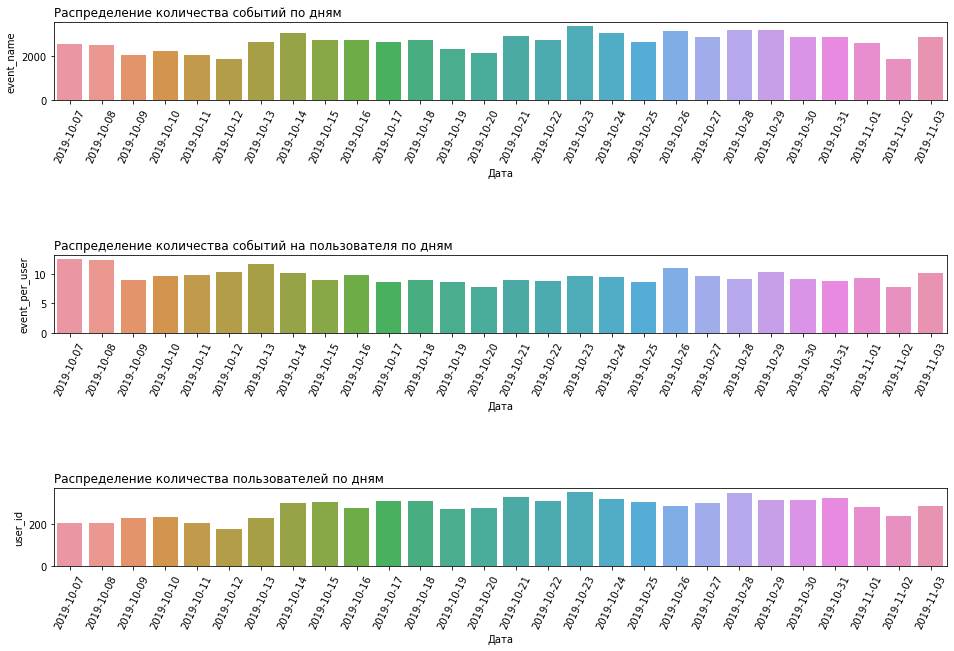

In [22]:
plt.figure(figsize=(16,10))
plt.subplot(3, 1, 1)

sns.barplot(x='event_dt', y='event_name', data=data_grouped) 
plt.title('Распределение количества событий по дням', loc = 'left') 
plt.xlabel('Дата')
plt.xticks(rotation= 65)

plt.subplot(3, 1, 2)
sns.barplot(x='event_dt', y='event_per_user', data=data_grouped) 
plt.title('Распределение количества событий на пользователя по дням', loc = 'left') 
plt.xlabel('Дата')
plt.xticks(rotation= 65)

plt.subplot(3, 1,3)
sns.barplot(x='event_dt', y='user_id', data=data_grouped) 
plt.title('Распределение количества пользователей по дням', loc = 'left') 
plt.xlabel('Дата')
plt.xticks(rotation= 65)
plt.subplots_adjust(wspace=2, hspace=2)
plt.show()

Распределние пользователей и событий по дням достаточно равномерное

<a id="duration"></a> 
### Определение длительности сессии

In [23]:
data = data.sort_values(['user_id', 'event_date'])
data['diff'] = data.groupby('user_id')['event_date'].diff(1)
data['diff_sec'] = data['diff'].dt.total_seconds()

In [24]:
data['diff_sec'].describe(percentiles = [ 0.75, 0.85, 0.90, 0.95 ])

count      69,904.00
mean       13,981.17
std        91,977.26
min             0.00
50%            71.00
75%           180.00
85%           375.00
90%         1,021.00
95%        37,476.05
max     2,296,194.00
Name: diff_sec, dtype: float64

Предположим что если между событиями у пользователя проходит более 20 минут (округлим 1021 /60), то сессия завершается

<a id="session"></a> 
### Выделение сессий

In [26]:
g = (data.groupby('user_id')['event_date'].diff() > pd.Timedelta('20Min')).cumsum()
data['session_id'] = data.groupby(['user_id', g], sort=False).ngroup() + 1

In [27]:
#проверим на одном из пользователей
data.query('user_id=="0001b1d5-b74a-4cbf-aeb0-7df5947bf349"')

,event_time,event_name,user_id,event_date,event_dt,diff,diff_sec,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45,2019-10-07,NaT,NaN,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31,2019-10-07,0 days 00:00:46,46.00,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05,2019-10-07,0 days 00:00:34,34.00,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20,2019-10-07,0 days 00:02:15,135.00,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30,2019-10-07,0 days 00:02:10,130.00,1
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43,2019-10-07,0 days 00:00:13,13.00,1
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:46:31,2019-10-07,0 days 00:00:48,48.00,1
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:47:32,2019-10-07,0 days 00:01:01,61.00,1
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:49:41,2019-10-07,0 days 00:02:09,129.00,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09 18:33:55,2019-10-09,2 days 04:44:14,"189,854.00",2


Похоже сессии разделены корректно

Определим какие события у нас чаще всего становятся первыми для сессий

In [28]:
data.groupby('session_id').agg({'event_name': 'first'})['event_name'].value_counts().to_frame()

,event_name
tips_show,4092
photos_show,1775
search_1,1472
map,1325
show_contacts,609
search_4,529
advert_open,449
search_7,169
search_6,143
favorites_add,119


Чаще всего это "пользователь увидел рекомендованные объявления", "просмотр фотографий в объявлении", "разные события, связанные с поиском по сайту" и "пользователь открыл карту размещенных объявлений"

<a id="dau_mau"></a> 
### Расчет DAU (количество уникальных пользователей в день) и WAU (количество уникальных пользователей в неделю)

In [29]:
table = data.groupby(['user_id', 'session_id']).agg({'event_date': ['min', 'max']}).reset_index()
table.columns = table.columns.map(''.join)

In [30]:
table.columns = ['user_id', 'session_id', 'session_start', 'session_end']

In [31]:
table['session_year'] = table['session_start'].dt.year
table['session_week'] = table['session_start'].dt.week
table['session_date'] = table['session_start'].dt.date

dau_total = (
    table.groupby(['session_date'])
    .agg({'user_id': 'nunique'})
    .mean()
) 
wau_total = (
    table.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)

In [32]:
f'Количество уникальных пользователей в день {int(dau_total)}, количество уникальных пользователей в неделю {int(wau_total)}'

'Количество уникальных пользователей в день 277, количество уникальных пользователей в неделю 1381'

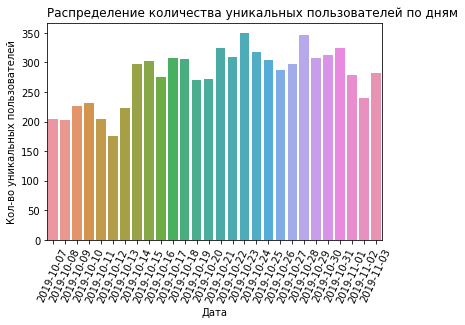

In [33]:
sns.barplot(x= 'session_date', y='user_id', data=table.groupby(['session_date']).agg({'user_id': 'nunique'}).reset_index()) 
plt.title('Распределение количества уникальных пользователей по дням', loc = 'left') 
plt.xlabel('Дата')
plt.ylabel('Кол-во уникальных пользователей')
plt.xticks(rotation= 65)
plt.show()

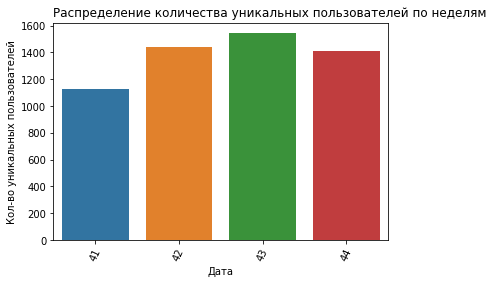

In [34]:
sns.barplot(x= 'session_week', y='user_id', data=table.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'}).reset_index()) 
plt.title('Распределение количества уникальных пользователей по неделям', loc = 'left') 
plt.xlabel('Дата')
plt.ylabel('Кол-во уникальных пользователей')
plt.xticks(rotation= 65)
plt.show()

Видно что после 12-10-2019, т.е. начиная с 42 недели количество уникальных пользовалей увеличилось

<a id="segmentation"></a>
## Сегментация пользователей на основе действий

In [35]:
segmentation = (data.pivot_table(index = 'user_id', columns = 'event_name', 
                                values = 'session_id', aggfunc = 'count')
                .reset_index().drop(columns = 'tips_show').fillna(0))

In [36]:
segmentation 

event_name,user_id,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,show_contacts,tips_click
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.00,5.00,2.00,0.00,33.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00
2,00463033-5717-4bf1-91b4-09183923b9df,0.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.00,0.00,0.00,6.00,0.00,0.00,0.00,1.00,2.00,6.00,2.00,6.00,0.00,0.00
4,00551e79-152e-4441-9cf7-565d7eb04090,0.00,3.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4290,ffcf50d9-293c-4254-8243-4890b030b238,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,0.00,0.00,0.00,0.00,7.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


<a id="std"></a>
### Стандартизируем данные

In [37]:
scaler = StandardScaler() 
# уберем целевое действие show_contacts и то что за ним должно обычно следовать contacts_call
x_sc = scaler.fit_transform(segmentation.drop(columns = ['user_id', 'show_contacts', 'contacts_call']))

<a id="dendrogram"></a>
### Матрица расстояний

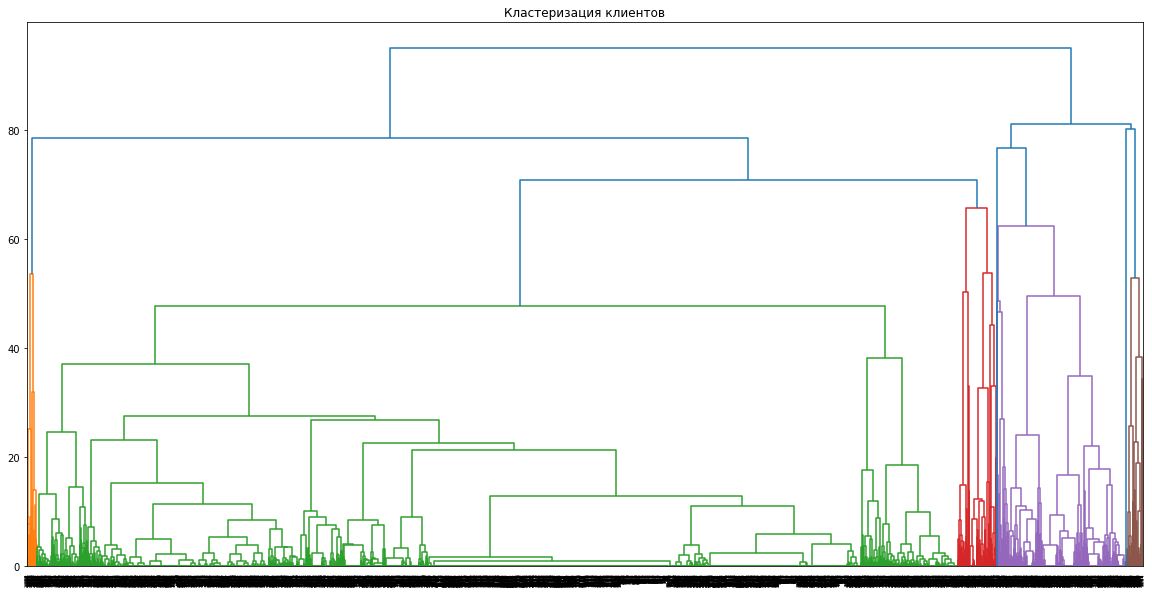

In [38]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

Предварительно можно выделить 2 группы, остальные слишком малы

<a id="KMeans"></a>
### Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров пользователей

In [40]:
km_1 = KMeans(n_clusters=2, random_state=0) # задаём число кластеров, равное 7, и фиксируем значение random_state для воспроизводимости результата
labels_1 = km_1.fit_predict(x_sc) 
# сохраняем метки кластера в поле нашего датасета
segmentation['cluster_1'] = labels_1

In [41]:
segmentation['cluster_1'].value_counts()

0    4169
1     124
Name: cluster_1, dtype: int64

<a id="metrix"></a>
### Сравнение мерик (retention rate, время проведенное в приложении, частота действий, конверсия в целевое действие) по каждому из полученных кластеров

In [42]:
segmentation.groupby('cluster_1').mean().T

cluster_1,0,1
event_name,,
advert_open,1.05,14.49
contacts_call,0.13,0.00
favorites_add,0.30,1.23
map,0.72,6.96
photos_show,2.36,1.43
search_1,0.83,0.25
search_2,0.05,1.03
search_3,0.08,1.47
search_4,0.10,2.28


In [43]:
data = data.merge(segmentation[['user_id','cluster_1']], how = 'left', on = 'user_id')

In [44]:
t = data.groupby('cluster_1').agg({'user_id': 'nunique', 'event_name':'count',  'session_id': 'nunique'}).reset_index()

In [45]:
t.columns = ['cluster_1', 'num_users', 'event_number', 'session_number']

In [46]:
t['event_per_user'] = t['event_number']/t['num_users']
t['sessions_per_user'] = t['session_number']/t['num_users']

In [47]:
t

,cluster_1,num_users,event_number,session_number,event_per_user,sessions_per_user
0,0,4169,63600,9935,15.26,2.38
1,1,124,10597,1040,85.46,8.39


- "0" самый многочисленный кластер с низкой активностью и плохой конвертацией в показ контактов, возможно зашли на сайт, ничего не зацепило и ушли, не пользуются поиском, не просматривают карту, "надо работать"
- "1" наш фаворит, очень активный,  они чаще всех кликают по рекомендованному объявлению и лучше всех осуществляют целевое действие

Сравним retention rate по каждому из кластеров

In [48]:
#определим время начала сессии для каждого пользователя и самую первую сессию
session_start_t = data.groupby(['user_id', 'session_id'])['event_date'].min().reset_index()
first_date_table = data.groupby(['user_id'])['event_date'].min().reset_index()


In [49]:
retention_calc = session_start_t .merge(first_date_table[['user_id', 'event_date']], how = 'left', 
                           on = ['user_id'])
retention_calc.rename(columns = {'event_date_x': 'session_start','event_date_y' : 'first_ts'}, inplace = True) 
retention_calc['dt'] = pd.to_datetime(retention_calc['first_ts']).dt.date

In [50]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 11, 3).date()
horizon_days = 6

# создаём опцию «игнорировать горизонт»
ignore_horizon = False

In [51]:
# рассчитываем максимально возможную дату привлечения
last_suitable_acquisition_date = observation_date
if not ignore_horizon:
    last_suitable_acquisition_date = observation_date - timedelta(
        days=horizon_days - 1
    )

# исключаем пользователей, пришедших после максимальной даты привлечения
result_raw = retention_calc.query('dt <= @last_suitable_acquisition_date')

result_raw = result_raw.merge(segmentation[['user_id', 'cluster_1']], how = 'left', on = 'user_id')

In [52]:
result_raw

,user_id,session_id,session_start,first_ts,dt,cluster_1
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45,2019-10-07 13:39:45,2019-10-07,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:55,2019-10-07 13:39:45,2019-10-07,0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:30,2019-10-07 13:39:45,2019-10-07,0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2019-10-22 11:18:14,2019-10-07 13:39:45,2019-10-07,0
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,2019-10-19 21:34:33,2019-10-19 21:34:33,2019-10-19,0
...,...,...,...,...,...,...
9965,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10971,2019-11-02 01:16:48,2019-10-12 00:57:21,2019-10-12,0
9966,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10972,2019-11-02 18:01:27,2019-10-12 00:57:21,2019-10-12,0
9967,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10973,2019-11-02 19:25:53,2019-10-12 00:57:21,2019-10-12,0
9968,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10974,2019-11-03 14:32:55,2019-10-12 00:57:21,2019-10-12,0


In [53]:
def retention_by_cluster(cluster):
    result_raw_c = result_raw.query('cluster_1 == @cluster')
    result_raw_c['lifetime'] = (
    result_raw_c['session_start'] - result_raw_c['first_ts']).dt.days  # вычисляем лайфтайм каждой сессии в днях

    result_grouped = result_raw_c.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique')  # строим таблицу удержания

    cohort_sizes = (
    result_raw_c.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
    )  # вычисляем размеры когорт

    result_grouped = cohort_sizes.merge(
    result_grouped, on='dt', how='left'
    ).fillna(0)  # объединяем размеры когорт и таблицу удержания

    # делим данные таблицы удержания на размеры когорт
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем из результата все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[['cohort_size'] + list(range(horizon_days))]

    # во время деления все значения cohort_size превратились в единицу
    # восстанавливаем — они понадобятся нам позже
    result_grouped['cohort_size'] = cohort_sizes
    return result_grouped


retention rate по кластеру 0


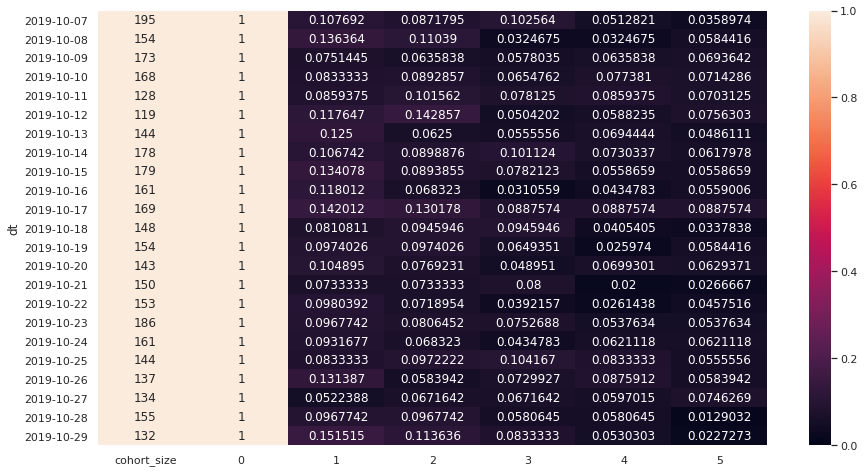

retention rate по кластеру 1


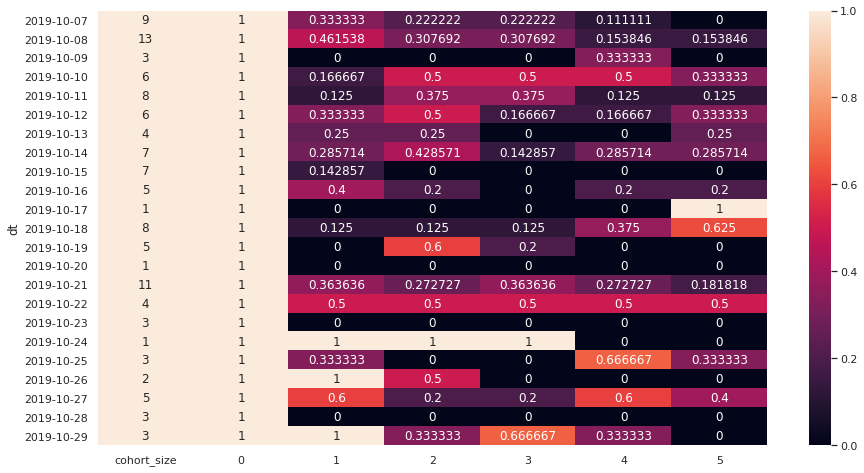

In [54]:
for i in range(2):
    print(f'retention rate по кластеру {i}')
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.heatmap(data = retention_by_cluster(i), vmin=0, vmax=1, annot = True, fmt='g')

    plt.show()

In [55]:
for i in range(2):
    print(f'retention rate по кластеру {i}')
    display(retention_by_cluster(i))

retention rate по кластеру 0


,cohort_size,0,1,2,3,4,5
dt,,,,,,,
2019-10-07,195,1.00,0.11,0.09,0.10,0.05,0.04
2019-10-08,154,1.00,0.14,0.11,0.03,0.03,0.06
2019-10-09,173,1.00,0.08,0.06,0.06,0.06,0.07
2019-10-10,168,1.00,0.08,0.09,0.07,0.08,0.07
2019-10-11,128,1.00,0.09,0.10,0.08,0.09,0.07
2019-10-12,119,1.00,0.12,0.14,0.05,0.06,0.08
2019-10-13,144,1.00,0.12,0.06,0.06,0.07,0.05
2019-10-14,178,1.00,0.11,0.09,0.10,0.07,0.06
2019-10-15,179,1.00,0.13,0.09,0.08,0.06,0.06


retention rate по кластеру 1


,cohort_size,0,1,2,3,4,5
dt,,,,,,,
2019-10-07,9,1.00,0.33,0.22,0.22,0.11,0.00
2019-10-08,13,1.00,0.46,0.31,0.31,0.15,0.15
2019-10-09,3,1.00,0.00,0.00,0.00,0.33,0.00
2019-10-10,6,1.00,0.17,0.50,0.50,0.50,0.33
2019-10-11,8,1.00,0.12,0.38,0.38,0.12,0.12
2019-10-12,6,1.00,0.33,0.50,0.17,0.17,0.33
2019-10-13,4,1.00,0.25,0.25,0.00,0.00,0.25
2019-10-14,7,1.00,0.29,0.43,0.14,0.29,0.29
2019-10-15,7,1.00,0.14,0.00,0.00,0.00,0.00


Коэффициент удержания выше по пользвателям кластера "1", что логично, это более активные пользователи, по ним так же выше конвертация в целевое действие, однако их небольшое количество (максимальный размер когорты за период - 13 человек), не дает сделать однозначных выводов.
Что можно сказать:
- пользователи заходят в приложение не каждый день, что логично - это не инстаграмм, однако не появлясь несколько дней, вполне могут вернуться, так что если пользователи не появляются в приложении, это не значит что оно ему не нужно, возможно стоит направить письмо с рекомендациями на основе его поисков например
- кластер 1 лучше и по удержанию и по конверсии в целевое действие, сравнивать конверсию по когортам у них трудно, ввиду малого числа пользоватлей но, например 62% пользоватлей когорты от 18.10.2019 что то заставило вернуться на 5 день, возможно какая то акция
- По кластеру 1, с которым нам и нужно работать, удержание на 6й день в среднем составляет 5,5%, самые "качественные" пользователи пришли к нам 17.10.2019, и наоборот - 28-29.10.2019

In [56]:
data = data.merge(session_start_t[['user_id', 'session_id', 'event_date']], how = 'left', 
                           on = ['user_id', 'session_id'])

In [57]:
data = data.rename(columns = {'event_date_y': 'session_st'})

In [58]:
#найдем события, которые были первыми в сессиях
data['is_first_event_in_session'] = data['event_date_x'] == data['session_st']
data['time_on_page'] = data.groupby(['session_id'])['event_date_x'].diff(1)
#найдем время просмотра 1 страницы
data['time_on_page'] = data.groupby(['session_id'])['time_on_page'].shift(-1)/ np.timedelta64(1, 's')
data

,event_time,event_name,user_id,event_date_x,event_dt,diff,diff_sec,session_id,cluster_1,session_st,is_first_event_in_session,time_on_page
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45,2019-10-07,NaT,NaN,1,0,2019-10-07 13:39:45,True,46.00
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31,2019-10-07,0 days 00:00:46,46.00,1,0,2019-10-07 13:39:45,False,34.00
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05,2019-10-07,0 days 00:00:34,34.00,1,0,2019-10-07 13:39:45,False,135.00
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20,2019-10-07,0 days 00:02:15,135.00,1,0,2019-10-07 13:39:45,False,130.00
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30,2019-10-07,0 days 00:02:10,130.00,1,0,2019-10-07 13:39:45,False,13.00
...,...,...,...,...,...,...,...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 15:51:23,2019-11-03,0 days 00:00:27,27.00,10975,0,2019-11-03 15:36:01,False,34.00
74193,2019-11-03 15:51:57.899997,show_contacts,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 15:51:57,2019-11-03,0 days 00:00:34,34.00,10975,0,2019-11-03 15:36:01,False,943.00
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 16:07:40,2019-11-03,0 days 00:15:43,943.00,10975,0,2019-11-03 15:36:01,False,38.00
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 16:08:18,2019-11-03,0 days 00:00:38,38.00,10975,0,2019-11-03 15:36:01,False,7.00


In [59]:
print('Среднее время просмотра страниц {:.2f}'.format(data['time_on_page'].mean()))

Среднее время просмотра страниц 112.61


In [60]:
print('Среднее время просмотра страниц у пользователей совершивших целевое действие {:.2f}'
      .format(data.query('user_id == @filtered_users_list')['time_on_page'].mean()))

Среднее время просмотра страниц у пользователей совершивших целевое действие 118.59


In [61]:
print('Среднее время просмотра страниц у пользователей не совершивших целевое действие {:.2f}'
      .format(data.query('user_id != @filtered_users_list')['time_on_page'].mean()))

Среднее время просмотра страниц у пользователей не совершивших целевое действие 109.17


Найдем события которые чаще всего предшествовали целевому событию

In [62]:
data[data['event_name'].shift(-1)=='show_contacts'].groupby('event_name')['event_time'].count().to_frame()

,event_time
event_name,
advert_open,80
contacts_call,209
favorites_add,48
map,63
photos_show,445
search_1,211
search_3,2
search_5,34
show_contacts,1533


Очень странно что чаще всего пользователь переходит к просмотру контактов после того как увидел рекомендованные объявления, но при этом не после клика по рекомендованному объявлению, т.е. нельзя утверждать что пользователь посмотрел именно контакт рекомендованного объявления

Клик по рекомендованному объявлению очень редко сразу же конвертируется в просмотр контактов, опять возвращаемся к вопросу о качестве рекомендаций, самостоятельный поиск явно предпочтительнее для пользователя

Просмотр фото чаще сподвигает на целевое действие чем поиск, значит фото в приложении важны

На втором месте у нас событие photos_show, посмотрим сколько времени требуется пользователю для того что бы его совершить

In [63]:
t_photo = data.query('event_name =="photos_show"').merge(first_date_table, how = 'left', on = 'user_id')

In [64]:
t_photo = t_photo.groupby(['user_id', 'event_date'])['event_date_x'].min().to_frame().reset_index()
t_photo['time_before_photo'] = (t_photo['event_date_x']-t_photo['event_date'])/ np.timedelta64(1, 's')

In [65]:
print('Среднее время до просмотра фото {:.2f} секунд'.format(t_photo['time_before_photo'].mean()))

Среднее время до просмотра фото 38234.05 секунд


In [66]:
print('Среднее время до просмотра фото  у пользователей совершивших целевое действие {:.2f} секунд'
      .format(t_photo.query('user_id == @filtered_users_list')['time_before_photo'].mean()))

Среднее время до просмотра фото  у пользователей совершивших целевое действие 42494.72 секунд


In [67]:
print('Среднее время до просмотра фото  у пользователей не совершивших целевое действие {:.2f} секунд'
      .format(t_photo.query('user_id != @filtered_users_list')['time_before_photo'].mean()))

Среднее время до просмотра фото  у пользователей не совершивших целевое действие 36323.52 секунд


Среднее время до просмотра фото  у пользователей не совершивших целевое меньше чем, у пользователей просмотревших контакты, это может объясняться тем что такие пользователи более тщательно выбирают объявления, но в целом то что у пользователей занимает по 10 часов, что бы добраться до фото - настораживает.
Посмотрим может это влияние выбросов

In [68]:
t_photo['time_before_photo'].describe(percentiles = [ 0.95 ])

count       1,095.00
mean       38,234.05
std       184,757.87
min             0.00
50%             0.00
95%       170,192.00
max     2,253,287.00
Name: time_before_photo, dtype: float64

Действительно есть очень странные пользователи

In [69]:
t_photo.query('time_before_photo == 2253287.00')

,user_id,event_date,event_date_x,time_before_photo
198,2b39c650-c582-4195-ba16-ade26ee0a72f,2019-10-07 09:38:35,2019-11-02 11:33:22,"2,253,287.00"


In [70]:
data.query('user_id == "2b39c650-c582-4195-ba16-ade26ee0a72f"')

,event_time,event_name,user_id,event_date_x,event_dt,diff,diff_sec,session_id,cluster_1,session_st,is_first_event_in_session,time_on_page
13655,2019-10-07 09:38:35.311491,search_1,2b39c650-c582-4195-ba16-ade26ee0a72f,2019-10-07 09:38:35,2019-10-07,NaT,NaN,2036,0,2019-10-07 09:38:35,True,42.00
13656,2019-10-07 09:39:17.534842,search_1,2b39c650-c582-4195-ba16-ade26ee0a72f,2019-10-07 09:39:17,2019-10-07,0 days 00:00:42,42.00,2036,0,2019-10-07 09:38:35,False,NaN
13657,2019-11-02 11:31:15.570827,search_1,2b39c650-c582-4195-ba16-ade26ee0a72f,2019-11-02 11:31:15,2019-11-02,26 days 01:51:58,"2,253,118.00",2037,0,2019-11-02 11:31:15,True,127.00
13658,2019-11-02 11:33:22.374323,photos_show,2b39c650-c582-4195-ba16-ade26ee0a72f,2019-11-02 11:33:22,2019-11-02,0 days 00:02:07,127.00,2037,0,2019-11-02 11:31:15,False,NaN


Например этот пользователь только во вторую сессию дошел до просмотра фто, при этом между сеессиями прошел почти месяц

In [71]:
#пересчитаем на медиану
print('Среднее время до просмотра фото  у пользователей совершивших целевое действие {:.2f} секунд'
      .format(t_photo.query('user_id == @filtered_users_list')['time_before_photo'].median()))

Среднее время до просмотра фото  у пользователей совершивших целевое действие 12.00 секунд


In [72]:
print('Среднее время до просмотра фото  у пользователей не совершивших целевое действие {:.2f} секунд'
      .format(t_photo.query('user_id != @filtered_users_list')['time_before_photo'].median()))

Среднее время до просмотра фото  у пользователей не совершивших целевое действие 0.00 секунд


Посмотрим на все события

In [73]:
t = data.merge(first_date_table, how = 'left', on = 'user_id')
t = t.groupby(['user_id', 'event_name','event_date'])['event_date_x'].min().to_frame().reset_index()
t['time_before_action'] = (t['event_date_x']-t['event_date'])/ np.timedelta64(1, 's')

In [74]:
is_ta = t['user_id'].isin(filtered_users_list)

In [76]:
t['is_ta']=is_ta        
t.pivot_table(index = 'event_name', columns = 'is_ta', values = 'time_before_action', aggfunc = 'median')

is_ta,False,True
event_name,,
advert_open,121.00,"5,167.00"
contacts_call,NaN,"2,701.00"
favorites_add,863.00,"4,799.50"
map,0.00,18.00
photos_show,0.00,12.00
search_1,0.00,0.00
search_2,20.00,74.00
search_3,106.00,"5,234.00"
search_4,0.00,171.00


Похоже пользователи, которые в дальнейшем от нас уходят не посмотрев контакты, быстрее добавляют в целом совершают все действия в приложении в более короткий срок от начала его использования, единственное отличие это событие "пользователь увидел рекомендованные объявления". Почему то у пользователей не совершавших целовое действие по данному событию идет какой то лаг

In [77]:
t.query('is_ta == False').groupby('user_id').agg({'event_name': 'first'})['event_name'].value_counts().to_frame()

,event_name
map,721
tips_show,707
photos_show,624
advert_open,613
favorites_add,153
search_5,107
search_4,105
tips_click,97
search_2,96
search_1,80


In [78]:
t.query('is_ta == True').groupby('user_id').agg({'event_name': 'first'})['event_name'].value_counts().to_frame()

,event_name
show_contacts,211
contacts_call,192
map,188
advert_open,138
photos_show,138
favorites_add,57
search_2,17
search_4,14
search_1,14
search_5,11


Найдем событие, которым чаще всего заканчивались сессии пользователей

In [79]:
session_end_t = data.groupby(['user_id', 'session_id'])['event_date_x'].max().reset_index()

In [80]:
data = data.merge(session_end_t, how = 'left', 
                           on = ['user_id', 'session_id'])

In [81]:
data = data.rename(columns = {'event_date_x_y': 'session_end'})

In [82]:
data['is_last_event_in_session'] = data['event_date_x_x'] == data['session_end']
data.groupby('event_name')['is_last_event_in_session'].count()

event_name
advert_open       6164
contacts_call      541
favorites_add     1417
map               3881
photos_show      10012
search_1          3506
search_2           324
search_3           522
search_4           701
search_5          1049
search_6           460
search_7           222
show_contacts     4529
tips_click         814
tips_show        40055
Name: is_last_event_in_session, dtype: int64

Чаще всего пользователи завершают сессию после события "пользователь увидел рекомендованные объявления". Возможно это так же в копилку к проблемам с рекомендациями, на втором месте "contacts_call" - здесь все логично, а вот на 3 месте - "map", почему то карта размещенных объявлений не сподвигает на их открытие

<a id="hypothesis"></a>
## Проверка гипотез

<a id="1hypothesis"></a>
### Две группы пользователей (одни - установили приложение по ссылке из yandex ,другие — из google) демонстрируют разную конверсию в просмотры контактов

In [83]:
# дополним данные информацией об источнике установки
hyp_1 = data.merge(sources, how = 'left', on = 'user_id')
# проверим количество пользователей в каждой из групп
hyp_1.groupby('sourse')['user_id'].nunique()

sourse
google    1129
other     1230
yandex    1934
Name: user_id, dtype: int64

Сформулируем гипотезы:

Нулевая гипотеза:  Доли пользователей, совершивших рассматриваеммое событие (просмотр контактов), равны.

Альтернативная гипотеза: Доли пользователей, совершивших рассматриваеммое событие, различаются

In [84]:
# разделим пользователей на группы в зависимости от источника
group_a = hyp_1.query('sourse == "google"')
group_b = hyp_1.query('sourse == "yandex"')
# найдем число пользователей, совершивших событие contacts_show в каждой  групп
group_a_event = group_a.query('event_name == "show_contacts"')['user_id'].nunique()
group_b_event = group_b.query('event_name == "show_contacts"')['user_id'].nunique()
#Посчитаем долю пользователей, совершивших это событие
p1 = group_a_event/group_a['user_id'].nunique()
p2 = group_b_event/group_b['user_id'].nunique()

In [85]:
# Проверим гипотезу о равенстве долей

p_combined = (group_a_event
              + group_b_event) / (group_a['user_id'].nunique() + group_b['user_id'].nunique())
difference = p1 - p2 
z_value = difference / mth.sqrt(
p_combined * (1 - p_combined) * (1 / group_a['user_id'].nunique() + 1 / group_b['user_id'].nunique())) 
distr = st.norm(0, 1)
alpha = 0.05
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<a id="1hypothesis"></a>
### Две группы пользователей (одни - совершают в приложении ,больше действий(к примеру больше 15 ,другие — меньше) демонстрируют разную конверсию в просмотры контактов

In [86]:
# разделим пользоватлей на группы
user_a = list(data.groupby('user_id')['event_name'].count().to_frame().query('event_name <=15').index)
user_b = list(data.groupby('user_id')['event_name'].count().to_frame().query('event_name > 15').index)

In [87]:
group_a = data.query('user_id ==@user_a')
group_b = data.query('user_id ==@user_b')

Сформулируем гипотезы:

Нулевая гипотеза:  Доли пользователей, совершивших рассматриваеммое событие (просмотр контактов), равны.

Альтернативная гипотеза: Доли пользователей, совершивших рассматриваеммое событие, различаются

In [88]:
# найдем число пользователей, совершивших событие contacts_show в каждой  групп
group_a_event = group_a.query('event_name == "show_contacts"')['user_id'].nunique()
group_b_event = group_b.query('event_name == "show_contacts"')['user_id'].nunique()
#Посчитаем долю пользователей, совершивших это событие
p1 = group_a_event/group_a['user_id'].nunique()
p2 = group_b_event/group_b['user_id'].nunique()

In [89]:
# Проверим гипотезу о равенстве долей

p_combined = (group_a_event
              + group_b_event) / (group_a['user_id'].nunique() + group_b['user_id'].nunique())
difference = p1 - p2 
z_value = difference / mth.sqrt(
p_combined * (1 - p_combined) * (1 / group_a['user_id'].nunique() + 1 / group_b['user_id'].nunique())) 
distr = st.norm(0, 1)
alpha = 0.05
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


<a id="conclusion"></a>
## Общий вывод

В результате проведенной предобработки данных:
- определено что пропуски и дубликаты в данных отсутствуют
- названия колонок приведены в соответствии со snake case
- изменен формат колонки event.time

В результате исследовательского анализа данных:
- объединены события contacts_show и show_contacts как идентичные
- определено, что самое частое событие "пользователь увидел рекомендованные объявления", однако событие которое логично за ним бы следовало "пользователь кликнул по рекомендованному объявлению" только на 5 месте, возможно систему рекомендаций можно настроить лучше
- определено количество пользователей совершивших целевое действие - 981 из 4293, это 22,8%
- определено что распределение пользователей и событий по дням достаточно равномерное
- выделены сессии пользователей
- чаще всего первыми событиями в сессии становятся "пользователь увидел рекомендованные объявления", "просмотр фотографий в объявлении", "разные события, связанные с поиском по сайту" и "пользователь открыл карту размещенных объявлений"
- рассчитаны количество уникальных пользователей в день 277, количество уникальных пользователей в неделю 1381, согласно графикам видно что после 12-10-2019, т.е. начиная с 42 недели количество уникальных пользовалей увеличилось

Проведена сегментация пользователей на основе количества совершаемых ими действий:
- Выделено 2 кластера
- "0" самый многочисленный кластер с низкой активностью и плохой конвертацией в показ контактов, возможно зашли на сайт, ничего не зацепило и ушли, не пользуются поиском, не просматривают карту, "надо работать"
- "1" наш фаворит, очень активный,  они чаще всех кликают по рекомендованному объявлению и лучше всех осуществляют целевое действие

Коэффициент удержания выше по пользвателям кластера "1", что логично, это более активные пользователи, по ним так же выше конвертация в целевое действие, однако их небольшое количество (максимальный размер когорты за период - 13 человек), не дает сделать однозначных выводов.
Что можно сказать:
- пользователи заходят в приложение не каждый день, что логично - это не инстаграмм, однако не появлясь несколько дней, вполне могут вернуться
- кластер 1 лучше и по удержанию и по конверсии в целевое действие, сравнивать конверсию по когортам у них трудно, ввиду малого числа пользоватлей но, например 62% пользоватлей когорты от 18.10.2019 что то заставило вернуться на 5 день, возможно какая то акция
- По кластеру 1, с которым нам и нужно работать, удержание на 6й день в среднем составляет 5,5%, самые "качественные" пользователи пришли к нам 17.10.2019, и наоборот - 28-29.10.2019
- среднее время просмотра страниц у пользоватлей, совершивших целевое действие выше
- среднее время до просмотра фото  у пользователей не совершивших целевое меньше чем, у пользователей просмотревших контакты, это может объясняться тем что такие пользователи более тщательно выбирают объявления
- чаще всего пользователи завершают сессию после события "пользователь увидел рекомендованные объявления". Возможно это так же в копилку к проблемам с рекомендациями, на втором месте "contacts_call" - здесь все логично, а вот на 3 месте - "map", почему то карта размещенных объявлений не сподвигает на их открытие
- чаще всего пользователь переходит к просмотру контактов после того как увидел рекомендованные объявления, но при этом не после клика по рекомендованному объявлению, т.е. нельзя утверждать что пользователь посмотрел именно контакт рекомендованного объявления
- клик по рекомендованному объявлению очень редко сразу же конвертируется в просмотр контактов, опять возвращаемся к вопросу о качестве рекомендаций, самостоятельный поиск явно предпочтительнее для пользователя
- просмотр фото чаще сподвигает на целевое действие чем поиск, значит фото в приложении важны

Проведена проверка гипотез:
- Нет оснований считать доли пользователей совершивших целевое действие в группах, установивших приложение из yandex и google разными
- Есть статистически значимая разница между долями пользователей совершивших целевое действие в группах, где пользователи совершают больше и меньше 15 действий в приложении


**Проблемы в данных:**
Основная проблема при анализе имеющихся данных отсутсвие ID объявлений, непонятно, например, какое объявление пользователю показали как рекомендованное, а какое он добавил в избранное, посмотрел ли он фото этого же объявления и т.д.

search_1 — search_7 — разные события, связанные с поиском по сайту, это поиски по различным критериям, в различных разделах, по фильтрам? Например мы видим из анализа что за search_1 чаще следует целевое действие чем за остальными поисками, но дело ли здесь в виде поиска или просто пользователь находит то что нужно по первому запросу(что конечно хорошо, если так).


**Рекомендации:**
- Детализировать логи, возможно добавить id объявлений, для возможности более детального анализа, добавить данные по объявлениям, например наличие фото и т.д.
- Поработать над улучшением системы рекомендаций (показ рекомендованного объявления плохо конвертируется в клик по нему, кроме того показ рекомендованных объявлений по логике должен быть первым событием для пользоватля, однако это не всегда так)
- Мониторить пользователей,  которые долго не появляются в приложении и направить письмо с рекомендациями на основе их поисков (либо об изменениях  в просмотренных объявлениях и пр.)